# Optimizing Robot Control Policies Using the Bat Algorithm
The purpose of this lab is to apply the Bat Algorithm (BA) to a robot path planning problem.
We will learn how BA can be used to optimize control policies and find efficient paths for a robot navigating a 2D environment represented as a map or grid.

# Concept Overview:

**Bat Algorithm (BA):**

A metaheuristic inspired by the echolocation behavior of bats.

Each bat represents a potential solution (in this lab: a movement policy for the robot).

Bats adjust their positions (solutions) according to parameters such as frequency, velocity, loudness, and pulse rate to find the optimal path.

**Map Representation:**

The robot environment is modeled as a grid map where:

- 0 → free cell (robot can move)

- 1 → obstacle (blocked cell)


**Policy Optimization:**

Each bat’s position encodes a sequence of robot actions (Up, Down, Left, Right).

The algorithm evaluates how well each policy navigates the robot from start to goal without hitting obstacles or going out of bounds.

The fitness function measures the total path cost, considering:

- Step penalties

- Obstacle collisions

- Distance remaining to goal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

def load_or_generate_map(path="map.csv", size=(10, 10), obstacle_prob=0.25, seed=42):
    if os.path.exists(path):
        print(f"Map loaded from '{path}'")
        grid = pd.read_csv(path, header=None).values.astype(int)
    else:
        print("Generating new random map and saving to map.csv")
        np.random.seed(seed)
        grid = (np.random.rand(*size) < obstacle_prob).astype(int)
        grid[0, 0] = 0  # start
        grid[-1, -1] = 0  # goal
        pd.DataFrame(grid).to_csv(path, index=False, header=False)
    return grid

In [2]:
grid = load_or_generate_map()
rows, cols = grid.shape
start = (0, 0)
goal = (rows - 1, cols - 1)

ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_NAMES = ["↑", "↓", "←", "→"]

Generating new random map and saving to map.csv


In [3]:
def simulate_policy(actions, grid, start, goal, max_steps=100):
    pos = np.array(start)
    total_cost = 0
    path = [tuple(pos)]

    # Limit simulation to the length of the policy or max_steps
    # (In this case, policy length is the primary driver)
    for act_idx in actions:
        move = np.array(ACTIONS[int(act_idx) % 4])
        new_pos = pos + move

        # Check bounds & obstacles
        if (0 <= new_pos[0] < grid.shape[0]) and (0 <= new_pos[1] < grid.shape[1]) and (grid[tuple(new_pos)] == 0):
            pos = new_pos
        else:
            # Penalty for hitting a wall or obstacle
            total_cost += 5

        # Cost for taking a step
        total_cost += 1
        path.append(tuple(pos))

        if tuple(pos) == goal:
            break

    # Distance to goal penalty (Manhattan distance)
    dist = np.abs(pos[0] - goal[0]) + np.abs(pos[1] - goal[1])
    total_cost += dist * 2
    return total_cost, path

In [4]:
def bat_optimize(grid, n_bats=20, n_iter=50, policy_len=40):
    # Initialize bat population (policies)
    bats = np.random.randint(0, 4, (n_bats, policy_len))
    v = np.zeros_like(bats, dtype=float)
    freq_min, freq_max = 0, 2
    loudness = np.ones(n_bats) * 1.5 # Start with higher loudness
    pulse_rate = np.ones(n_bats) * 0.1 # Initial pulse rate
    pulse_rate_final = 0.85

    def fitness(policy):
        cost, _ = simulate_policy(policy, grid, start, goal)
        return cost

    fitness_vals = np.array([fitness(b) for b in bats]) # initial
    best_idx = np.argmin(fitness_vals)
    best = bats[best_idx].copy()
    best_fit = fitness_vals[best_idx]
    history = [best_fit]

    for t in range(n_iter):
        for i in range(n_bats):
            # Update frequency, velocity, and position
            f = freq_min + (freq_max - freq_min) * np.random.rand()
            v[i] += (bats[i] - best) * f
            new_sol = np.round(bats[i] + v[i]).astype(int) % 4 # Ensure actions are 0-3

            # Local search (random walk)
            if random.random() > pulse_rate[i]:
                eps = np.random.uniform(-1, 1, policy_len)
                # Local search around the current best solution
                new_sol = np.round(best + eps * np.mean(loudness)).astype(int) % 4

            new_fit = fitness(new_sol)

            # Acceptance criteria
            if (new_fit < fitness_vals[i]) and (random.random() < loudness[i]):
                bats[i] = new_sol
                fitness_vals[i] = new_fit
                # Update loudness and pulse rate
                loudness[i] *= 0.9 # Loudness decreases
                pulse_rate[i] = pulse_rate[i] * (1 - np.exp(-0.9 * (t + 1))) # Pulse rate increases

            # Update global best
            if fitness_vals[i] < best_fit:
                best_fit = fitness_vals[i]
                best = bats[i].copy()

        history.append(best_fit)
        if (t + 1) % 10 == 0:
            print(f"Iteration {t + 1}/{n_iter}, Best cost: {best_fit:.2f}")

    return best, best_fit, history

In [22]:
best_policy, best_cost, hist = bat_optimize(grid = grid , n_bats=200, n_iter=300, policy_len=60)
print("\nBest cost:", best_cost)
print("Best policy actions (first 25):", [ACTION_NAMES[a] for a in best_policy[:25]])

Iteration 10/300, Best cost: 90.00
Iteration 20/300, Best cost: 90.00
Iteration 30/300, Best cost: 90.00
Iteration 40/300, Best cost: 88.00
Iteration 50/300, Best cost: 60.00
Iteration 60/300, Best cost: 60.00
Iteration 70/300, Best cost: 60.00
Iteration 80/300, Best cost: 60.00
Iteration 90/300, Best cost: 60.00
Iteration 100/300, Best cost: 60.00
Iteration 110/300, Best cost: 60.00
Iteration 120/300, Best cost: 60.00
Iteration 130/300, Best cost: 60.00
Iteration 140/300, Best cost: 58.00
Iteration 150/300, Best cost: 58.00
Iteration 160/300, Best cost: 58.00
Iteration 170/300, Best cost: 58.00
Iteration 180/300, Best cost: 58.00
Iteration 190/300, Best cost: 58.00
Iteration 200/300, Best cost: 58.00
Iteration 210/300, Best cost: 58.00
Iteration 220/300, Best cost: 58.00
Iteration 230/300, Best cost: 58.00
Iteration 240/300, Best cost: 58.00
Iteration 250/300, Best cost: 58.00
Iteration 260/300, Best cost: 58.00
Iteration 270/300, Best cost: 50.00
Iteration 280/300, Best cost: 50.00
I


Optimized robot path (first 20 steps): [(np.int64(0), np.int64(0)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(2)), (np.int64(1), np.int64(2)), (np.int64(1), np.int64(2)), (np.int64(2), np.int64(2)), (np.int64(2), np.int64(2)), (np.int64(2), np.int64(3)), (np.int64(3), np.int64(3)), (np.int64(4), np.int64(3)), (np.int64(5), np.int64(3)), (np.int64(6), np.int64(3)), (np.int64(5), np.int64(3)), (np.int64(6), np.int64(3)), (np.int64(7), np.int64(3)), (np.int64(7), np.int64(4)), (np.int64(7), np.int64(5)), (np.int64(8), np.int64(5))]


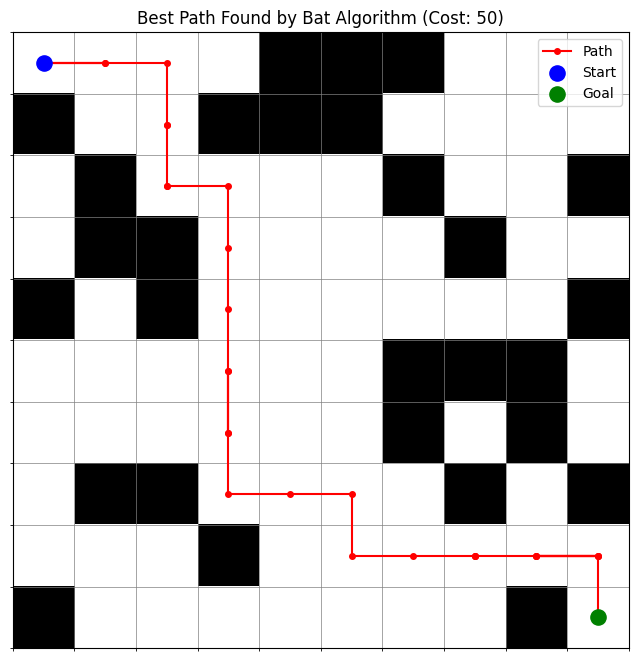

In [23]:
cost, path = simulate_policy(best_policy, grid, start, goal)
print("\nOptimized robot path (first 20 steps):", path[:20])

# Visualization
plt.figure(figsize=(8, 8))
# Create a colormap: 0=white, 1=black
cmap = plt.cm.colors.ListedColormap(['white', 'black'])
plt.imshow(grid, cmap=cmap, interpolation='nearest')

path = np.array(path)
plt.plot(path[:, 1], path[:, 0], 'r-o', markersize=4, label='Path')
plt.scatter(start[1], start[0], c='blue', s=120, label='Start', zorder=5)
plt.scatter(goal[1], goal[0], c='green', s=120, label='Goal', zorder=5)

# Set ticks to be at the center of the cells
ax = plt.gca()
ax.set_xticks(np.arange(-.5, grid.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, grid.shape[0], 1), minor=True)
ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])

plt.legend()
plt.title(f"Best Path Found by Bat Algorithm (Cost: {best_cost})")
plt.show()

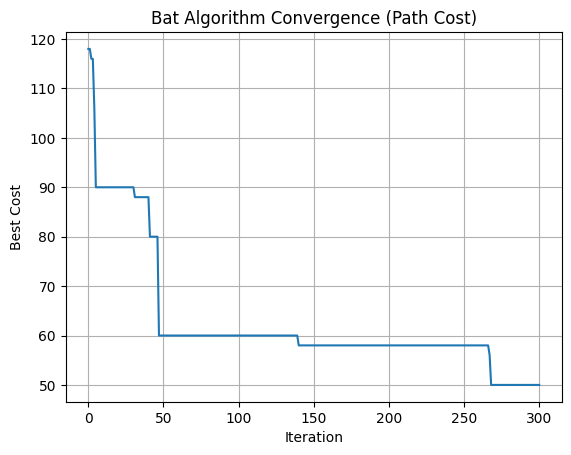

In [24]:
plt.figure()
plt.plot(hist)
plt.title("Bat Algorithm Convergence (Path Cost)")
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.grid(True)
plt.show()